In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\Data\Cleaned\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [3]:
# --- 🚚 OPERATIONAL & FULFILLMENT KPIs ---

# ✅ STEP 1: Filter valid rows for metrics (ship_ts >= purchase_ts_cleaned)
df_valid = df[
    (df['ship_ts'].notna()) &
    (df['ship_ts'] >= df['purchase_ts_cleaned'])
].copy()

# ✅ STEP 2: Average Shipping Time (Overall)
avg_shipping_time = (
    df_valid
    .groupby('purchase_month')['time_to_ship']
    .mean()
    .reset_index(name='avg_shipping_time_days')
)

# ✅ STEP 3: Delayed Shipping % (ship_ts > purchase_ts_cleaned)
DELAY_THRESHOLD_DAYS = 1
df_valid['delayed_shipping'] = df_valid['time_to_ship'] > DELAY_THRESHOLD_DAYS

delayed_shipping = (
    df_valid
    .groupby('purchase_month')['delayed_shipping']
    .mean()
    .reset_index(name='delayed_shipping_%')
)

# Convert to percentage
delayed_shipping['delayed_shipping_%'] *= 100


# ✅ STEP 4: Orders Shipped Before Purchase (Data Quality Flag)
invalid_shipping = (
    df[df['ship_ts'] < df['purchase_ts_cleaned']]
    .groupby('purchase_month')['order_id']
    .count()
    .reset_index(name='orders_shipped_before_purchase')
)

# ✅ STEP 5: Average Shipping Time by Region
shipping_by_region = (
    df_valid
    .groupby(['purchase_month', 'region'])['time_to_ship']
    .mean()
    .unstack()
    .fillna(0)
    .reset_index()
)
shipping_by_region.columns = [
    'purchase_month'
] + [f"avg_ship_days_region_{col}" for col in shipping_by_region.columns[1:]]

# ✅ STEP 6: Average Shipping Time by Marketing Channel
shipping_by_channel = (
    df_valid
    .groupby(['purchase_month', 'marketing_channel_cleaned'])['time_to_ship']
    .mean()
    .unstack()
    .fillna(0)
    .reset_index()
)
shipping_by_channel.columns = [
    'purchase_month'
] + [f"avg_ship_days_channel_{col}" for col in shipping_by_channel.columns[1:]]

# ✅ STEP 7: Merge All Operational KPIs
operational_kpis = (
    avg_shipping_time
    .merge(delayed_shipping, on='purchase_month', how='left')
    .merge(invalid_shipping, on='purchase_month', how='left')
    .merge(shipping_by_region, on='purchase_month', how='left')
    .merge(shipping_by_channel, on='purchase_month', how='left')
)

operational_kpis


,purchase_month,avg_shipping_time_days,delayed_shipping_%,orders_shipped_before_purchase,avg_ship_days_region_APAC,avg_ship_days_region_EMEA,avg_ship_days_region_LATAM,avg_ship_days_region_NA,avg_ship_days_region_unknown,avg_ship_days_channel_affiliate,avg_ship_days_channel_direct,avg_ship_days_channel_email,avg_ship_days_channel_social media,avg_ship_days_channel_unknown
0,1,2.036374,67.711248,34,2.34188,2.006329,1.966667,2.028402,1.4,2.0625,2.059322,1.891386,2.148148,2.153846
1,2,1.989143,65.657143,75,1.868613,1.971053,2.066667,2.02439,1.666667,2.030769,1.990448,1.940972,2.347826,2.076923
2,3,1.994087,66.592757,156,2.0,1.968121,2.055556,2.016591,1.666667,1.836735,1.969945,2.122093,2.3,2.75
3,4,1.98767,65.996106,182,2.020619,1.995392,1.772727,1.980443,2.5,2.06383,2.008026,1.865741,1.777778,2.6
4,5,1.994865,65.532734,169,2.037037,1.982405,2.0,2.004065,1.25,2.121951,1.989699,1.953488,2.25,2.25
5,6,2.390614,66.183575,168,1.938144,2.930599,2.216216,1.960294,3.0,1.85,2.508432,1.830688,2.068966,1.8
6,7,1.961917,65.003283,170,2.128788,1.918367,2.096774,1.963939,2.0,1.82,1.965719,1.995816,1.62963,2.272727
7,8,2.006238,66.375546,194,2.038168,2.006135,2.37931,1.989861,1.0,2.107692,1.996848,2.042918,2.117647,1.736842
8,9,1.995833,66.875,257,2.012048,1.965394,2.441176,2.006865,1.75,1.982759,1.997351,1.974843,2.04,2.444444
9,10,2.023605,67.453505,151,2.03125,2.020968,1.962963,2.025994,3.0,1.878049,2.045495,1.964126,1.8,1.0


In [4]:
operational_kpis.to_csv("operational_kpis.csv", index=False)


In [5]:
# --- 🚚 OPERATIONAL & FULFILLMENT KPIs ---

# ✅ STEP 1: Filter valid rows with reasonable shipping times
MAX_REASONABLE_SHIPPING_DAYS = 30  # Adjust based on your business

df_valid = df[
    (df['ship_ts'].notna()) &
    (df['ship_ts'] >= df['purchase_ts_cleaned'])
].copy()

df_operational = df_valid[df_valid['time_to_ship'] <= MAX_REASONABLE_SHIPPING_DAYS].copy()
df_extreme_shipping = df_valid[df_valid['time_to_ship'] > MAX_REASONABLE_SHIPPING_DAYS].copy()
df_invalid_shipping = df[df['ship_ts'] < df['purchase_ts_cleaned']].copy()

# Set delay threshold
DELAY_THRESHOLD_DAYS = 7
df_operational['delayed_shipping'] = df_operational['time_to_ship'] > DELAY_THRESHOLD_DAYS

# ✅ STEP 2: Overall Summary Metrics
total_orders = len(df)
operational_records = len(df_operational)
extreme_shipping_records = len(df_extreme_shipping)
invalid_shipping_records = len(df_invalid_shipping)
data_quality_rate = round((operational_records / total_orders) * 100, 2)

overall_avg_shipping_time = round(df_operational['time_to_ship'].mean(), 2)
overall_delayed_rate = round((df_operational['delayed_shipping'].sum() / len(df_operational)) * 100, 2)
median_shipping_time = df_operational['time_to_ship'].median()
percentile_95_shipping = df_operational['time_to_ship'].quantile(0.95)

operational_summary = pd.DataFrame({
    'metric': [
        'total_orders',
        'operational_records_(used_for_analysis)',
        'extreme_shipping_outliers_(>30_days)',
        'invalid_shipping_(ship<purchase)',
        'data_quality_rate_%',
        'overall_avg_shipping_time_days',
        'median_shipping_time_days',
        '95th_percentile_shipping_days',
        'overall_delayed_shipping_rate_%',
        'delay_threshold_days'
    ],
    'value': [
        total_orders,
        operational_records,
        extreme_shipping_records,
        invalid_shipping_records,
        data_quality_rate,
        overall_avg_shipping_time,
        median_shipping_time,
        percentile_95_shipping,
        overall_delayed_rate,
        DELAY_THRESHOLD_DAYS
    ]
})

# ✅ STEP 3: Shipping Time Distribution (using operational data)
shipping_distribution = pd.cut(
    df_operational['time_to_ship'],
    bins=[0, 1, 3, 7, 14, 30],
    labels=['Same Day (0-1)', 'Fast (1-3)', 'Standard (3-7)', 'Slow (7-14)', 'Very Slow (14-30)'],
    right=True
).value_counts().reset_index()
shipping_distribution.columns = ['shipping_speed', 'order_count']
shipping_distribution['percentage'] = (
    shipping_distribution['order_count'] / shipping_distribution['order_count'].sum() * 100
).round(2)
shipping_distribution = shipping_distribution.sort_values('order_count', ascending=False)

# ✅ STEP 4: Outlier Analysis (separate table for the extreme cases)
outlier_analysis = pd.DataFrame({
    'category': ['Extreme Shipping (>30 days)', 'Invalid Shipping (ship<purchase)'],
    'count': [len(df_extreme_shipping), len(df_invalid_shipping)],
    'percentage_of_total': [
        round((len(df_extreme_shipping) / total_orders) * 100, 2),
        round((len(df_invalid_shipping) / total_orders) * 100, 2)
    ]
})

# ✅ STEP 5-11: Continue with monthly analysis using df_operational
avg_shipping_time = (
    df_operational
    .groupby('purchase_month')['time_to_ship']
    .mean()
    .reset_index()
    .rename(columns={'time_to_ship': 'avg_shipping_time_days'})
)

delayed_shipping = (
    df_operational
    .groupby('purchase_month')['delayed_shipping']
    .mean()
    .reset_index()
    .rename(columns={'delayed_shipping': 'delayed_shipping_%'})
)
delayed_shipping['delayed_shipping_%'] *= 100

invalid_shipping_monthly = (
    df_invalid_shipping
    .groupby('purchase_month')['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'invalid_shipping_count'})
)

extreme_shipping_monthly = (
    df_extreme_shipping
    .groupby('purchase_month')['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'extreme_shipping_count'})
)

shipping_by_region = (
    df_operational
    .groupby(['purchase_month', 'region'])['time_to_ship']
    .mean()
    .unstack()
    .fillna(0)
    .reset_index()
)
shipping_by_region.columns = [
    'purchase_month'
] + [f"avg_ship_days_region_{col}" for col in shipping_by_region.columns[1:]]

shipping_by_channel = (
    df_operational
    .groupby(['purchase_month', 'marketing_channel_cleaned'])['time_to_ship']
    .mean()
    .unstack()
    .fillna(0)
    .reset_index()
)
shipping_by_channel.columns = [
    'purchase_month'
] + [f"avg_ship_days_channel_{col}" for col in shipping_by_channel.columns[1:]]

shipping_by_platform = (
    df_operational
    .groupby(['purchase_month', 'purchase_platform'])['time_to_ship']
    .mean()
    .unstack()
    .fillna(0)
    .reset_index()
)
shipping_by_platform.columns = [
    'purchase_month'
] + [f"avg_ship_days_platform_{col}" for col in shipping_by_platform.columns[1:]]

shipping_by_product = (
    df_operational
    .groupby('product_name_cleaned')
    .agg(
        avg_shipping_time=('time_to_ship', 'mean'),
        median_shipping_time=('time_to_ship', 'median'),
        total_orders=('order_id', 'count'),
        delayed_orders=('delayed_shipping', 'sum')
    )
    .reset_index()
)
shipping_by_product['delayed_rate_%'] = (
    shipping_by_product['delayed_orders'] / shipping_by_product['total_orders'] * 100
).round(2)
shipping_by_product = shipping_by_product.sort_values('avg_shipping_time', ascending=False)

# ✅ Merge All Monthly Operational KPIs
operational_kpis = (
    avg_shipping_time
    .merge(delayed_shipping, on='purchase_month', how='left')
    .merge(invalid_shipping_monthly, on='purchase_month', how='left')
    .merge(extreme_shipping_monthly, on='purchase_month', how='left')
    .merge(shipping_by_region, on='purchase_month', how='left')
    .merge(shipping_by_channel, on='purchase_month', how='left')
    .merge(shipping_by_platform, on='purchase_month', how='left')
)

# Fill missing values
operational_kpis['invalid_shipping_count'] = operational_kpis['invalid_shipping_count'].fillna(0).astype(int)
operational_kpis['extreme_shipping_count'] = operational_kpis['extreme_shipping_count'].fillna(0).astype(int)

# ✅ Display results
print("OPERATIONAL SUMMARY")
display(operational_summary)

print("\nOUTLIER ANALYSIS")
display(outlier_analysis)

print("\nSHIPPING DISTRIBUTION")
display(shipping_distribution)

print("\nMONTHLY OPERATIONAL KPIs")
display(operational_kpis)

print("\nSHIPPING BY PRODUCT")
display(shipping_by_product)



OPERATIONAL SUMMARY


,metric,value
0,total_orders,21864.00
1,operational_records_(used_for_analysis),19861.00
2,extreme_shipping_outliers_(>30_days),2.00
3,invalid_shipping_(ship<purchase),2000.00
4,data_quality_rate_%,90.84
5,overall_avg_shipping_time_days,2.00
6,median_shipping_time_days,2.00
7,95th_percentile_shipping_days,3.00
8,overall_delayed_shipping_rate_%,0.00
9,delay_threshold_days,7.00



OUTLIER ANALYSIS


,category,count,percentage_of_total
0,Extreme Shipping (>30 days),2,0.01
1,Invalid Shipping (ship<purchase),2000,9.15



SHIPPING DISTRIBUTION


,shipping_speed,order_count,percentage
0,Fast (1-3),13195,66.45
1,Same Day (0-1),6661,33.55
2,Standard (3-7),0,0.00
3,Slow (7-14),0,0.00
4,Very Slow (14-30),0,0.00



MONTHLY OPERATIONAL KPIs


,purchase_month,avg_shipping_time_days,delayed_shipping_%,invalid_shipping_count,extreme_shipping_count,avg_ship_days_region_APAC,avg_ship_days_region_EMEA,avg_ship_days_region_LATAM,avg_ship_days_region_NA,avg_ship_days_region_unknown,avg_ship_days_channel_affiliate,avg_ship_days_channel_direct,avg_ship_days_channel_email,avg_ship_days_channel_social media,avg_ship_days_channel_unknown,avg_ship_days_platform_mobile app,avg_ship_days_platform_website
0,1,2.036374,0.0,34,0,2.34188,2.006329,1.966667,2.028402,1.4,2.0625,2.059322,1.891386,2.148148,2.153846,2.060484,2.032489
1,2,1.989143,0.0,75,0,1.868613,1.971053,2.066667,2.02439,1.666667,2.030769,1.990448,1.940972,2.347826,2.076923,2.0,1.987678
2,3,1.994087,0.0,156,0,2.0,1.968121,2.055556,2.016591,1.666667,1.836735,1.969945,2.122093,2.3,2.75,2.12963,1.982329
3,4,1.98767,0.0,182,0,2.020619,1.995392,1.772727,1.980443,2.5,2.06383,2.008026,1.865741,1.777778,2.6,1.928571,1.992933
4,5,1.994865,0.0,169,0,2.037037,1.982405,2.0,2.004065,1.25,2.121951,1.989699,1.953488,2.25,2.25,1.975806,1.996513
5,6,1.993785,0.0,168,1,1.938144,2.023697,2.216216,1.960294,3.0,1.85,2.023629,1.830688,2.068966,1.8,1.867347,2.002963
6,7,1.961917,0.0,170,0,2.128788,1.918367,2.096774,1.963939,2.0,1.82,1.965719,1.995816,1.62963,2.272727,1.925234,1.964689
7,8,2.006238,0.0,194,0,2.038168,2.006135,2.37931,1.989861,1.0,2.107692,1.996848,2.042918,2.117647,1.736842,2.072072,2.00134
8,9,1.995833,0.0,257,0,2.012048,1.965394,2.441176,2.006865,1.75,1.982759,1.997351,1.974843,2.04,2.444444,2.066298,1.988499
9,10,2.023605,0.0,151,0,2.03125,2.020968,1.962963,2.025994,3.0,1.878049,2.045495,1.964126,1.8,1.0,1.94958,2.030493



SHIPPING BY PRODUCT


,product_name_cleaned,avg_shipping_time,median_shipping_time,total_orders,delayed_orders,delayed_rate_%
1,acer nitro v gaming laptop,2.051948,2.0,77,0,0.0
2,dell gaming mouse,2.025994,2.0,654,0,0.0
0,27in 4k gaming monitor,2.013555,2.0,4279,0,0.0
6,razer pro gaming headset,2.0,2.0,6,0,0.0
3,jbl quantum 100 gaming headset,1.999489,2.0,3911,0,0.0
7,sony playstation 5 bundle,1.994401,2.0,893,0,0.0
5,nintendo switch,1.992691,2.0,9440,0,0.0
4,lenovo ideapad gaming 3,1.985025,2.0,601,0,0.0


In [6]:
operational_summary.to_csv('operational_summary.csv', index=False)
outlier_analysis.to_csv('operational_outliers.csv', index=False)
shipping_distribution.to_csv('shipping_distribution.csv', index=False)
operational_kpis.to_csv('operational_kpis_monthly.csv', index=False)
shipping_by_product.to_csv('shipping_by_product.csv', index=False)

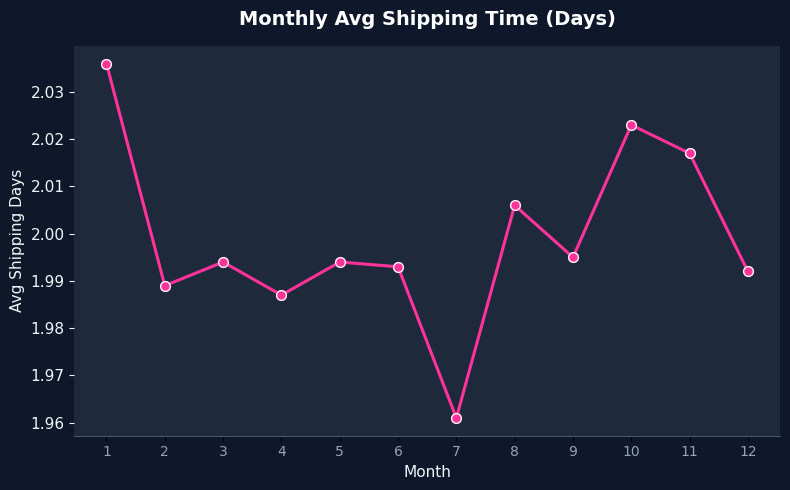

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Monthly Data
months = np.arange(1, 13)
avg_ship = [2.036, 1.989, 1.994, 1.987, 1.994, 1.993,
            1.961, 2.006, 1.995, 2.023, 2.017, 1.992]

# --- FIGURE SETUP ---
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor("#0f172a")
ax.set_facecolor("#1e293b")

# Line plot
ax.plot(
    months, avg_ship,
    marker="o", linewidth=2.2,
    markersize=7,
    color="#FF3399"   # your hot pink for contrast
)

# Marker edge contrast
ax.plot(months, avg_ship,
        marker="o", markersize=7,
        markeredgecolor="#f1f5f9",
        markerfacecolor="#FF3399",
        linestyle="")

# Title & Labels
ax.set_title("Monthly Avg Shipping Time (Days)",
             fontsize=14, color="white", fontweight="bold", pad=15)
ax.set_ylabel("Avg Shipping Days", color="#f1f5f9", fontsize=11)
ax.set_xlabel("Month", color="#f1f5f9", fontsize=11)

# Month ticks subtle color
ax.set_xticks(months)
ax.set_xticklabels(months, color="#94a3b8")

# Y-axis tick labels
ax.tick_params(axis='y', colors="#f1f5f9", labelsize=11)

# Baseline spine only
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color("#475569")

plt.tight_layout()
plt.show()


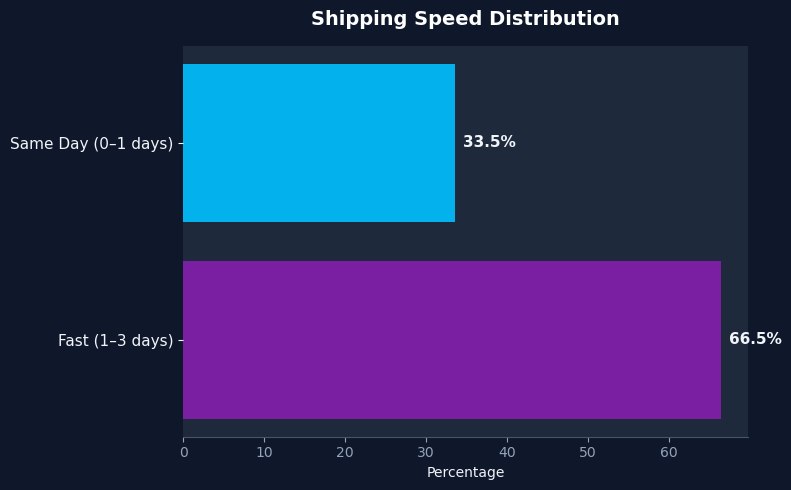

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
speeds = ["Fast (1–3 days)", "Same Day (0–1 days)"]
values = [66.45, 33.55]
colors = ["#7B1FA2", "#03b2ed"]  # gradient start → mid

# --- FIGURE SETUP ---
fig, ax = plt.subplots(figsize=(8, 5))
fig.patch.set_facecolor("#0f172a")     # full figure bg
ax.set_facecolor("#1e293b")            # plot bg

bars = ax.barh(speeds, values, color=colors, edgecolor="none")

# Value labels
for bar, val in zip(bars, values):
    ax.text(val + 1, bar.get_y() + bar.get_height()/2,
            f"{val:.1f}%",
            va="center", ha="left",
            fontsize=11, color="#f1f5f9", fontweight="bold")

# Title
ax.set_title("Shipping Speed Distribution", fontsize=14,
             fontweight="bold", color="white", pad=15)

# Axes styling
ax.set_xlabel("Percentage", color="#f1f5f9")
ax.set_ylabel("")
ax.tick_params(axis='x', colors="#94a3b8", labelsize=10)
ax.tick_params(axis='y', colors="#f1f5f9", labelsize=11)

# Remove top/right/left spines, keep only subtle bottom
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color("#475569")

plt.tight_layout()
plt.show()
